# Контекст

- новости российской газеты
- задача: предсказать название топика статьи

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns


from transformers import BertForSequenceClassification,\
                         BertTokenizerFast,\
                         TrainingArguments,\
                         Trainer,\
                         DataCollatorWithPadding


from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support,\
                            accuracy_score

import torch
from torch.utils.data import Dataset

# Чтение файла

In [2]:
data = pd.read_csv('rus_news.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 738968 entries, 0 to 738967
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   topic   738968 non-null  object
 1   text    738968 non-null  object
dtypes: object(2)
memory usage: 11.3+ MB


<Axes: xlabel='count', ylabel='topic'>

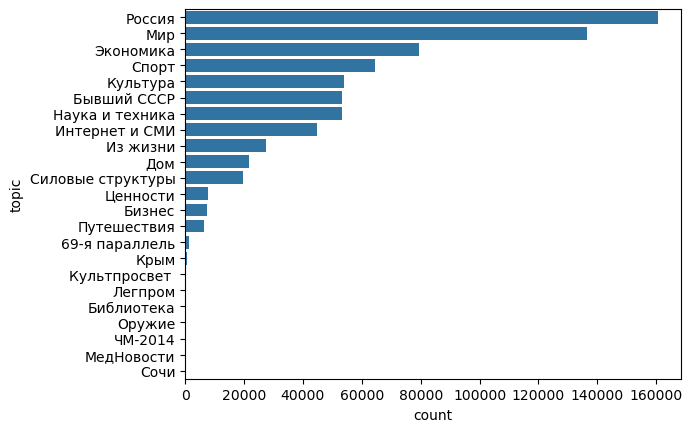

In [3]:
sns.barplot(
    data = data['topic'].value_counts().reset_index(),
    x = 'count',
    y = 'topic'
)

In [4]:
data['topic'].value_counts()

topic
Россия               160442
Мир                  136620
Экономика             79528
Спорт                 64413
Культура              53796
Бывший СССР           53402
Наука и техника       53136
Интернет и СМИ        44663
Из жизни              27605
Дом                   21734
Силовые структуры     19596
Ценности               7766
Бизнес                 7399
Путешествия            6408
69-я параллель         1268
Крым                    666
Культпросвет            340
Легпром                 114
Библиотека               65
Оружие                    3
ЧМ-2014                   2
МедНовости                1
Сочи                      1
Name: count, dtype: int64

In [5]:
delete_news = ['МедНовости', 'Сочи', 'ЧМ-2014', 'Оружие']
data = data[~data['topic'].isin(delete_news)]
data['topic'].value_counts()

topic
Россия               160442
Мир                  136620
Экономика             79528
Спорт                 64413
Культура              53796
Бывший СССР           53402
Наука и техника       53136
Интернет и СМИ        44663
Из жизни              27605
Дом                   21734
Силовые структуры     19596
Ценности               7766
Бизнес                 7399
Путешествия            6408
69-я параллель         1268
Крым                    666
Культпросвет            340
Легпром                 114
Библиотека               65
Name: count, dtype: int64

In [6]:
data = data.sample(frac = 1, random_state = 42)
labels_unique = data['topic'].unique().tolist()
num_labels = len(labels_unique)

print(labels_unique)
print(num_labels)

['Россия', 'Мир', 'Наука и техника', 'Из жизни', 'Дом', 'Спорт', 'Культура', 'Интернет и СМИ', 'Экономика', 'Бывший СССР', 'Культпросвет ', 'Ценности', '69-я параллель', 'Силовые структуры', 'Путешествия', 'Бизнес', 'Крым', 'Библиотека', 'Легпром']
19


In [7]:
id2label = {index : label for index, label in enumerate(labels_unique)}
label2id = {label : index for index, label in enumerate(labels_unique)}

In [8]:
data['label'] = data['topic'].map(label2id)
data.head()

,topic,text,label
510124,Россия,В Москве сочли политически мотивированным отка...,0
207822,Мир,Президент Венесуэлы Уго Чавес предложил отправ...,1
577908,Мир,Микроавтобус с музыкантами перуанской группы E...,1
726632,Россия,В Кремле считают результатом провокаций участи...,0
728234,Наука и техника,Только четвертый российский фрегат проекта 223...,2


# Скачивание модели и токенизатора

In [9]:
model = BertForSequenceClassification.from_pretrained(
    'DeepPavlov/rubert-base-cased',
    num_labels = 19,
    id2label = id2label,
    label2id = label2id)

tokenizer = BertTokenizerFast.from_pretrained(
    'DeepPavlov/rubert-base-cased',
    max_length = 512)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at DeepPavlov/rubert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [10]:
%%script false

print('Длина словаря: ', len(tokenizer.vocab))
tokenizer.SPECIAL_TOKENS_ATTRIBUTES

Couldn't find program: 'false'


# train_val_test split

In [11]:
%%script false

train, test = train_test_split(
    data,
    test_size = 0.2,
    stratify = data['label'],
    random_state = 42
)

val, test = train_test_split(
    test,
    test_size = 0.2,
    stratify = test['label'],
    random_state = 42
)

print(len(train), len(val), len(test))

Couldn't find program: 'false'


In [12]:
%%script false

train.to_csv('train.csv', index = False)
val.to_csv('val.csv', index = False)
test.to_csv('test.csv', index = False)

Couldn't find program: 'false'


In [13]:
train = pd.read_csv('train.csv')
val = pd.read_csv('val.csv')

train_for_economy, else_train = train_test_split(
    train,
    train_size = 0.3,
    random_state = 42,
    stratify = train['label']
)

val_for_economy, else_train = train_test_split(
    val,
    train_size = 0.3,
    random_state = 42,
    stratify = val['label']
)

train_for_economy.to_csv('train_for_economy.csv')
val_for_economy.to_csv('val_for_economy.csv')

# Токенизирование c помощью генератора

In [14]:
def tokenize_data_generator(df, batch_size):

    for i in range(0, len(df), batch_size):
    
        batch = df[i:i+batch_size]
        texts = batch['text']
        labels = batch['label'].to_list()

        tokenized_batch = tokenizer(
            texts.to_list(),
            padding=True,
            truncation=True,
            return_attention_mask = True
            )
        
        tokenized_batch = {'indput_ids': tokenized_batch['input_ids'],
                           'attention_mask': tokenized_batch['attention_mask'],
                           'labels': labels}

        yield tokenized_batch

# Dataset

In [15]:
class RusNewsDataset(Dataset):
    def __init__(self, mode, tokenizer):
        
        data = pd.read_csv(f'{mode}.csv')
        self.texts = data['text']
        self.labels = data['label']
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        labels = self.labels[idx]

        encoding = self.tokenizer(
                                text,
                                add_special_tokens=True,
                                max_length = 512,
                                padding=True,
                                truncation=True,
                                return_attention_mask=True,
                                return_tensors="pt",
                                 )

        return {
            "input_ids": encoding["input_ids"].flatten(),
            "attention_mask": encoding["attention_mask"].flatten(),
            "labels": torch.tensor(labels, dtype=torch.long),
        }
    


train_dataset = RusNewsDataset('train_for_economy', tokenizer)
val_dataset = RusNewsDataset('val_for_economy', tokenizer)

# Training args

In [ ]:
training_args = TrainingArguments(

    output_dir = 'training/model_points', # сохранение контрольных точек модели
    do_train = True, # мониторинг производительности
    do_eval = True,
    learning_rate=5e-5,
    num_train_epochs = 3,
    per_device_train_batch_size = 16,
    per_gpu_eval_batch_size = 16,
    warmup_steps = 100, # оптимизация скорости обучения
    weight_decay = 0.01, # регуляризация весов модели
    logging_strategy = 'steps', # аналог verbose с сохранением логов (также есть 'epoch')
    logging_dir = 'training/logs',
    save_steps = 500,
    # save_strategy = 'epoch',
    logging_steps = 50,
    eval_steps = 50,
    evaluation_strategy = 'steps',
    fp16 = True, # Указывает на использование смешанной точности и использует как 16-, так и 32-битные типы с плавающей запятой, чтобы 
                 # обучение проходило быстрее и занимало меньше памяти
    load_best_model_at_end = True,
    metric_for_best_model = 'f1',
    greater_is_better = True,
    report_to = 'wandb'
) 

# Функция подсчета метрик

In [18]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    Precision, Recall, f1, _ = precision_recall_fscore_support(labels, preds, average='macro')
    acc = accuracy_score(labels, preds)
    return {
            'Accuracy': acc,
            'F1': f1,
            'Precision': Precision,
            'Recall': Recall
            }

# Trainer

In [ ]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer,
                                        padding = True)

trainer = Trainer(

    model = model,
    args = training_args,
    train_dataset = train_dataset,
    eval_dataset = val_dataset,
    compute_metrics = compute_metrics,
    data_collator = data_collator,
)

trainer.train()